# Revising the spam detector to use neural networks

In [3]:
import pandas as pd
import seaborn as sns

In [4]:
df = pd.concat([pd.read_csv('YouTube-Spam-Collection-v1/YouTube01-Psy.csv'), 
                    pd.read_csv('YouTube-Spam-Collection-v1/Youtube02-KatyPerry.csv'), 
                    pd.read_csv('YouTube-Spam-Collection-v1/Youtube03-LMFAO.csv'), 
                    pd.read_csv('YouTube-Spam-Collection-v1/Youtube04-Eminem.csv'), 
                    pd.read_csv('YouTube-Spam-Collection-v1/Youtube05-Shakira.csv')])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1956 entries, 0 to 369
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   COMMENT_ID  1956 non-null   object
 1   AUTHOR      1956 non-null   object
 2   DATE        1711 non-null   object
 3   CONTENT     1956 non-null   object
 4   CLASS       1956 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 91.7+ KB


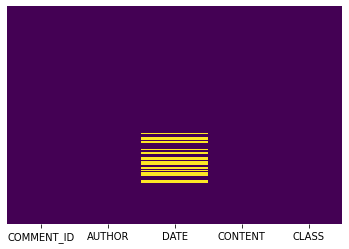

In [19]:
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=[]);
# as we can see, some data was missing from the Date column, but we are not interested in this column, so no worries

In [6]:
df['CLASS'].value_counts()

1    1005
0     951
Name: CLASS, dtype: int64

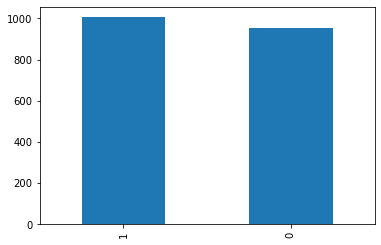

In [18]:
df['CLASS'].value_counts().plot(kind='bar'); 
# the target column is faily balanced 

### the StratifiedKFold tecnique

In [14]:
from sklearn.model_selection import StratifiedKFold

In [15]:
kfold = StratifiedKFold(n_splits=5)
splits = kfold.split(df, df['CLASS'])

In [16]:
for train, test in splits:
    print('Split')
    print(test, '\n') # It produces the indexes of the original dataset for those splits:

Split
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 

### build the neural network model

In [22]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np

In [27]:
def train_and_test(train_idx, test_idx):
    
    train_data = df['CONTENT'].iloc[train_idx]
    test_data = df['CONTENT'].iloc[test_idx]
    
    tokenizer = Tokenizer(num_words = 2000)
    
    tokenizer.fit_on_texts(train_data)
    
    train_input = tokenizer.texts_to_matrix(train_data, mode='tfidf') # options includes 'tfidf', 'binary', and 'freq'
    test_input = tokenizer.texts_to_matrix(test_data, mode='tfidf')
    
    train_input = train_input/np.amax(np.abs(train_input))
    test_input = test_input/np.amax(np.abs(test_input))
    
    train_input = train_input - np.mean(train_input)
    test_input = test_input - np.mean(test_input)
    
    train_class = df['CLASS'].iloc[train_idx]
    test_class = df['CLASS'].iloc[test_idx]
    
    network = models.Sequential()
    network.add(layers.Dense(512, activation='relu', input_shape=(2000,)))
    network.add(layers.Dropout(0.5))
    network.add(layers.Dense(256, activation='relu'))
    network.add(layers.Dropout(0.5))
    network.add(layers.Dense(1, activation='sigmoid'))
    
    network.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['acc'])
    
    network.fit(train_input, train_class, epochs=10, batch_size=256)
    
    score = network.evaluate(test_input, test_class)
    
    return score


In [46]:
kfold = StratifiedKFold(n_splits=5)
splits = kfold.split(df, df['CLASS'])
cvscores = []
for train_idx, test_idx in splits:
    loss, acc = train_and_test(train_idx, test_idx)
    cvscores.append(acc)

Epoch 1/10
1564/1564 [==============================] - 1s 594us/step - loss: 0.6830 - acc: 0.5013
Epoch 2/10
1564/1564 [==============================] - 0s 72us/step - loss: 0.6369 - acc: 0.5448
Epoch 3/10
1564/1564 [==============================] - 0s 67us/step - loss: 0.5585 - acc: 0.8229
Epoch 4/10
1564/1564 [==============================] - 0s 69us/step - loss: 0.4499 - acc: 0.9182
Epoch 5/10
1564/1564 [==============================] - 0s 66us/step - loss: 0.3093 - acc: 0.9508
Epoch 6/10
1564/1564 [==============================] - 0s 66us/step - loss: 0.1905 - acc: 0.9674
Epoch 7/10
1564/1564 [==============================] - 0s 79us/step - loss: 0.1198 - acc: 0.9712
Epoch 8/10
1564/1564 [==============================] - 0s 75us/step - loss: 0.0849 - acc: 0.9783
Epoch 9/10
1564/1564 [==============================] - 0s 71us/step - loss: 0.0617 - acc: 0.9795
Epoch 10/10
392/392 [==============================] - 0s 749us/step
Epoch 1/10
1565/1565 [==========================

In [47]:
cvscores

[0.9209183673469388,
 0.9437340153452686,
 0.948849104859335,
 0.9386189258312021,
 0.9309462915601023]

In [48]:
np.mean(cvscores) # the neural model acchive about 94% average accuracy 

0.9366133409885695

In [ ]:
prediction = 